# Aquaseca basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/flopy


## 2. Discretization and other inputs

In [2]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction
#print(dz)

## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET_1 = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 5e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m
#print(ET_locxy)
#print(rip_loc)

# ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows

# ET_rows2=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols2=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx))

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET_1 
#print("ET location(col, row)", ET_cols,ET_rows)
#print("ETrows_forced:", ET_rows_forced)
#print("ETrows:", ET_rows)
#print("ETcols:", ET_cols)
#print("ETrows2:", ET_rows2)
#print("ETcols2:", ET_cols2)

rip_rows_forced = (21.0, 28.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)


# rip_rows=(np.floor(nrow-rip_locxy[1][1]/dy),np.floor(nrow-rip_locxy[0][1]/dy)) #convert the y locations to rows
# rip_cols=(np.floor(rip_locxy[0][0]/dx),np.floor(rip_locxy[1][0]/dx)) #convert the y locations to rows
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 
#print("Riparian location(col, row)", rip_cols,rip_rows)

## Recharge
rech=4e-5  #m/d
rechxy=[(0,0),(0,36000)]  #recharge zone

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

rech_zone_forced = np.zeros((1, nrow,ncol))
rech_zone_forced[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech


rech_rows=(np.floor(nrow-rechxy[1][1]/dy),np.floor(nrow-rechxy[0][1]/dy))
rech_cols=(np.floor(rechxy[0][0]/dx),np.floor(rechxy[1][0]/dx))
#rech_zone=np.zeros(1,nrow,ncol)
#rech_zone[0,int(rech_rows[0]):int(rech_rows[1]),int(rech_cols[0]):int(rech_cols[1])]=rech
print("recharge location(col, row)", rech_cols,rech_rows)

#supply well
pumping = 0 #m3/day 
well_xy= [38000, 29000] #xy location of well 
well_row = np.floor((nrow)-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx) #convert the x location to a column
well_row = 29
well_col = 37
well_loc = (0,well_row, well_col)
well = [2,well_row, well_col, pumping] #Well loc shoudl be layer, row, column
print("well1 location(layer, col, row)", well_row, well_col)


#MW1
pumping2 = 0 #m3/day 
well2_xy= [25000, 25000] #xy location of well 
well2_row = np.floor((nrow)-(well2_xy[1]/dy)) #convert the y location to a row
well2_col=np.floor(well2_xy[0]/dx)-1 #convert the x location to a column
well2_loc = (0,well2_row, well2_col)
well2 = [0,well2_row, well2_col, pumping2] #Well loc shoudl be layer, row, column
print("well2 location(layer, col, row)", well2_row, well2_col)

#MW2
pumping3 = 0 #m3/day 
well3_xy= [12500, 12500] #xy location of well 
well3_row = np.floor((nrow)-(well3_xy[1]/dy)) #convert the y location to a row
well3_col=np.floor(well3_xy[0]/dx) #convert the x location to a column
well3_loc = (0,well3_row, well3_col)
well3 = [0,well3_row, well3_col, pumping3] 
print("well3 location(layer, col, row)", well3_row, well3_col)


#irrigation well
pumping4 = 0 #m3/day 
well4_row = 38 
well4_col = 12 
well4_loc = (0,well4_row, well4_col)
well4 = [0,well4_row, well4_col, pumping4] 
print("well4 location(layer, col, row)", well4_row, well4_col)

wel_spd = {0: [well, well2, well3, well4]}

## Boundary conditions
h_right = 70


## Timing
# nper = 1 #number of stress periods 
# steady = [True] #list noting the stress period type

recharge location(col, row) (0.0, 0.0) (14.0, 50.0)
well1 location(layer, col, row) 29 37
well2 location(layer, col, row) 25.0 24.0
well3 location(layer, col, row) 37.0 12.0
well4 location(layer, col, row) 38 12


## Boundary Conditions

In [3]:
#read in burn-in head values
print(os.getcwd())
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32) 
H_init[0,:,:] = np.loadtxt('toplayer_h_initR.csv', delimiter=",")
H_init[1,:,:] = np.loadtxt('midlayer_h_init.csv', delimiter=",")
H_init[2,:,:] = np.loadtxt('botlayer_h_init.csv', delimiter=",")
print(H_init[2,:,1])

# H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
# H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
# H_init[:, :, 49] = h_right    #replace first (right) col with desired head value

#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

/Users/rachelspinti/Documents/HWRS_582/Aguaseca_Project/Scenarios
[-999.99     -999.99     -999.99     -999.99     -999.99     -999.99
 -999.99     -999.99     -999.99       94.33324    94.392494   94.47427
   94.57664    94.70071    94.84932    95.02679    95.23894    95.49354
   95.80085    96.1746     96.63347    97.204834   97.95646    98.98425
  100.48695    98.9679     97.93281    97.18126    96.61644    96.16171
   95.790985   95.48621    95.23388    95.023636   94.847626   94.69984
   94.5757     94.47181    94.38597    94.31746    94.26829  -999.99
 -999.99     -999.99     -999.99     -999.99     -999.99     -999.99
 -999.99     -999.99    ]


## Seasons and Stressperiods

In [4]:
sp_peryr = 2   #number of seasons (with and wihtout ET. April-Sept and Oct-Mar)
sp1_len = 180  #sp lengths
sp2_len = 180
sim_years = 200
nper = int(sp_peryr*sim_years + 1)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
#print(steady)
steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
#print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen/30 #Changed to 30 so it reports out 6 or monthly
nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)
#print("Number of Steps", nstp)



## Boundary conditions
h_right = 70

## Set up varying ET & Pumping

In [5]:

ET_0 = 0
ET_SS = (24/50)*ET_1+(6/50)*rip_ET  #SS ET guess will be about 1/2 ET rate because ET is happening on half domain (but doesnt include rip area)
#print(ET_SS)

ET_val=np.tile([ET_1, ET_0],sim_years)
# ET_val=np.append(ET_SS,ET_val)

ET = {}
ET_zone1 = ET_zone           # normal et periods
ET_zone2 = ET_zone*0        # 0 ET Periods
for p in range(0,nper):    #loop over stress periods
    #print(ET_val[p])
    if int(p%2) == 0:     #see if odd or evetn 
        ET[p]=ET_zone1
    else: 
        ET[p]=ET_zone2
  #  print(np.sum(ET[p]))
#print(ET[9])


#WELL STRESS PERIODS
#init_well = [well, well2, well3, well4]
#
wel_spd = {0: well}    
    
burn = 0 #100 years plus 1
decade = 1 
pump = 47

for strper in range(0, nper):    
    if strper < burn:
        pumping = 0
        wel_spd[strper] =  [2,well_row, well_col, pumping]
    elif strper < (burn+decade*20): # 20 for 2 stress periods per 10 years
        pumping = round(pump * (decade**1.5)) *-1
        wel_spd[strper] =  [2,well_row, well_col, pumping]
    else:
        decade = decade + 1        
        pumping = round(pump * (decade**1.5)) *-1
        wel_spd[strper] =  [2,well_row, well_col, pumping]          
    
print(wel_spd)
xk= wel_spd.keys()
print(xk)
# print("These are all the keys in the dictionary")
# x = animals.keys()
# print(x)
# print()
# for i in len(wel_spd):
#     print(wel_spd{i:[:4]})

{0: [2, 29, 37, -47], 1: [2, 29, 37, -47], 2: [2, 29, 37, -47], 3: [2, 29, 37, -47], 4: [2, 29, 37, -47], 5: [2, 29, 37, -47], 6: [2, 29, 37, -47], 7: [2, 29, 37, -47], 8: [2, 29, 37, -47], 9: [2, 29, 37, -47], 10: [2, 29, 37, -47], 11: [2, 29, 37, -47], 12: [2, 29, 37, -47], 13: [2, 29, 37, -47], 14: [2, 29, 37, -47], 15: [2, 29, 37, -47], 16: [2, 29, 37, -47], 17: [2, 29, 37, -47], 18: [2, 29, 37, -47], 19: [2, 29, 37, -47], 20: [2, 29, 37, -133], 21: [2, 29, 37, -133], 22: [2, 29, 37, -133], 23: [2, 29, 37, -133], 24: [2, 29, 37, -133], 25: [2, 29, 37, -133], 26: [2, 29, 37, -133], 27: [2, 29, 37, -133], 28: [2, 29, 37, -133], 29: [2, 29, 37, -133], 30: [2, 29, 37, -133], 31: [2, 29, 37, -133], 32: [2, 29, 37, -133], 33: [2, 29, 37, -133], 34: [2, 29, 37, -133], 35: [2, 29, 37, -133], 36: [2, 29, 37, -133], 37: [2, 29, 37, -133], 38: [2, 29, 37, -133], 39: [2, 29, 37, -133], 40: [2, 29, 37, -244], 41: [2, 29, 37, -244], 42: [2, 29, 37, -244], 43: [2, 29, 37, -244], 44: [2, 29, 37, -

### Layering

In [6]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
#Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
#Kz[1,:,:] = K_vert2
#print(K_horiz)
#print(Kz)

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 


## Boundary Conditions

In [7]:
#original BCS

#print(ibound)
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value
#########################
#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

## Stream

In [8]:
#DEFINE RIVERS
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1
k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
#print(riv_spd)
#create dictionary of stress period data
riv_spd = {0: riv_sp}
#print(riv_spd)

In [9]:
#create model object
modelname = "Scenario3"
moddir="/Applications/MODFLOW/mf2005"
#moddir = "/Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mf2005"
#moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp=nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
#ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53) 

#Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone_forced, ipakcb=53)     #create rch object

#River - riv
riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd, ipakcb=53)

#Well - wel
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

oc_spd = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
#print(np.shape(oc_spd))
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=3000, iter1=200, relax = 0.96, damp = 0.5)

#write the inputs
m.write_input()   
m.evt.check()
m.oc.check()
m.oc.check()
m.lpf.check()
m.pcg.check()
m.riv.check()
m.rch.check()
m.dis.check()

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

check method not implemented for EVT Package.

OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


LPF PACKAGE DATA VALIDATION:
  1 Warning:
    STORAGECOEFFICIENT option is activated, storage values are read storage coefficients

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    zero or negative vertical hydraulic conductivity values
    negative horizontal anisotropy values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0
    zero or negative specific storage values
    specific storage values below checker threshold of 1e-06
    specific storage values above checker threshold of 0.01
    zero or negative 

 Solving:  Stress period:    15    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:     2    Ground-Wa

 Solving:  Stress period:    33    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     3    Ground-Wa

 Solving:  Stress period:    51    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     2    Ground-Wa

 Solving:  Stress period:    69    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     2    Ground-Wa

 Solving:  Stress period:    87    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     2    Ground-Wa

 Solving:  Stress period:   105    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     2    Ground-Wa

 Solving:  Stress period:   123    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     1    Ground-Wa

 Solving:  Stress period:   141    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     1    Ground-Wa

 Solving:  Stress period:   159    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     2    Ground-Wa

 Solving:  Stress period:   177    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:     2    Ground-Wa

 Solving:  Stress period:   194    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     6    Ground-Wa

 Solving:  Stress period:   212    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     6    Ground-Wa

 Solving:  Stress period:   230    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     5    Ground-Wa

 Solving:  Stress period:   249    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:     1    Ground-Wa

 Solving:  Stress period:   266    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:     5    Ground-Wa

 Solving:  Stress period:   284    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:     6    Ground-Wa

 Solving:  Stress period:   302    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:     5    Ground-Wa

 Solving:  Stress period:   321    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:     1    Ground-Wa

 Solving:  Stress period:   339    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:     2    Ground-Wa

 Solving:  Stress period:   357    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:     3    Ground-Wa

 Solving:  Stress period:   375    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:     3    Ground-Wa

 Solving:  Stress period:   393    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:     3    Ground-Wa

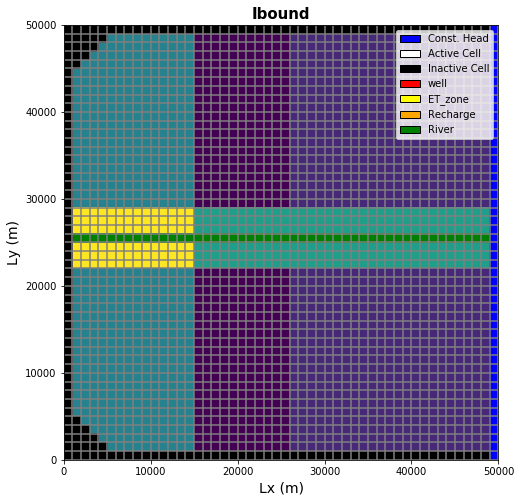

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
zones = ET_zone + rech_zone_forced
quadmesh = modelmap.plot_array(zones)
riv_plot = modelmap.plot_bc(ftype='RIV')
quadmesh = modelmap.plot_ibound(ibound[0])
#wel = modelmap.plot_bc(ftype='WEL')
#quadmesh = modelmap.plot_array(rech_zone_forced) #, color='purple')
#riv_plot = modelmap.plot_bc(ftype='RIV')
#chd_plot = modelmap.plot_bc(ftype='CHD')
#quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound()



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    mp.patches.Patch(color='red',label='well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET_zone',ec='black'),
                    mp.patches.Patch(color='orange',label='Recharge',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='black')
                   ])

plt.show(modelmap)
#plt.savefig('Domaingrid.png')

In [11]:
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times() # returns a list of timesteps
#times = []
# for t in range(len(perlen)):
#     if t == 0:
#         times.append(perlen[t])
#     else:
#         times.append(times[t-1]+perlen[t])
#print(times)

head = {} 
leakage = {}
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')

for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
    leakage['sp%s'%(stress_per)] = budgobj.get_data(text='RIVER LEAKAGE',totim=time) #append right face flow to frf list for ea stress per
    #fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per

In [12]:
print(len(head))

2401


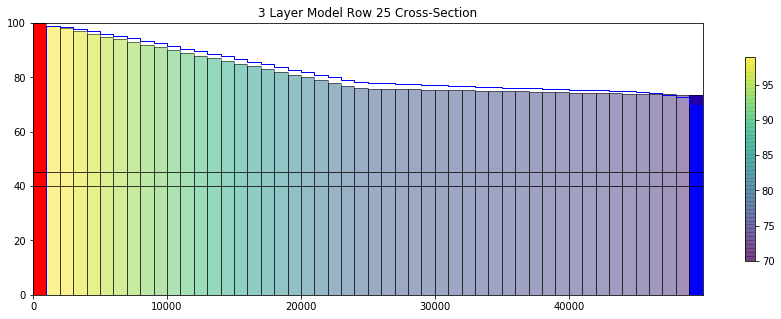

In [13]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 25}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

pc = xsect.plot_array(head['sp1200'], masked_values=[-999.99], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head['sp1200'])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head['sp1200'][0,:,:], masked_values=[999.], color='blue', lw=1)

## Plotting Heads

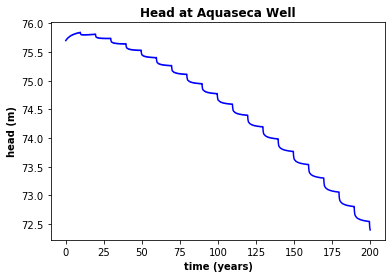

In [14]:

#plot a time series at cell left of river
#get time series for cell

cell_id1 = well_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at Aquaseca Well",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-') #plot the time series with points at each record

plt.savefig("Head_Aqua4.png",dpi=600)
plt.show()


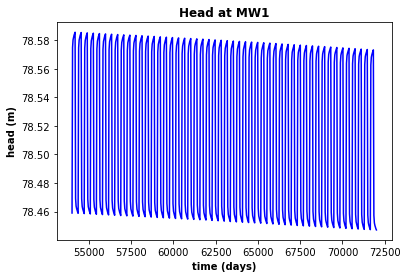

In [15]:

#plot a time series at cell left of river
#get time series for cell

cell_id1 = well2_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at MW1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[1800:, 0], time_series1[1800:, 1], 'b-') #plot the time series with points at each record

plt.savefig("Head_M1_4.png",dpi=600)
plt.show()


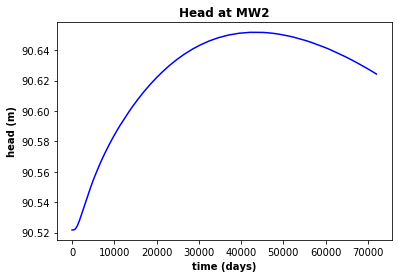

In [16]:

#plot a time series at cell left of river
#get time series for cell

cell_id1 = well3_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at MW2",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record

plt.savefig("Head_M2_4png", dpi=600)
plt.show()


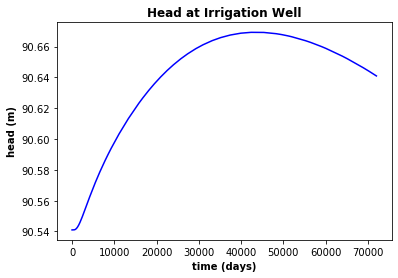

In [17]:

#plot a time series at cell left of river
#get time series for cell

cell_id1 = well4_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at Irrigation Well",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record

plt.savefig("Head_irri4.png", dpi=600)
plt.show()


In [18]:
well_loc
head['sp0'][0][19][38]
#head['sp0'][well_loc[0]][well_loc[1]][well_loc[2]]

#budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
#leakage = budgobj.get_data(text='RIVER LEAKAGE')
#print(leakage[0])
perflux = np.array(range(nper))

for i in range(nper):
    ##print("Stream Leakage for Stress period %s"%i)
    perflux[i] = 0
    for k in range(len(leakage['sp%s'%i][0])):
        #print(leakage['sp%s'%i][0][k][1])
        perflux[i] = perflux[i] + leakage['sp%s'%i][0][k][1]
        #flux[i] = flux[i] + leakage[0][k][1]
    
print(perflux)    


[19045 13535 12866 12354 11919 11551 11225 16463 16848 17119 17332 17509
 17656 12300 11750 11332 10980 10677 10422 15727 16162 16477 16727 16938
 17116 11775 11246 10853 10522 10251 10005 15340 15792 16114 16385 16606
 16794 11455 10942 10560 10242  9967  9730 15091 15548 15882 16156 16384
 16581 11240 10732 10353 10041  9764  9534 14912 15373 15712 15988 16224
 16420 11076 10576 10194  9881  9615  9389 14778 15239 15577 15857 16091
 16293 10945 10452 10080  9762  9497  9270 14674 15133 15473 15759 15986
 16192 10844 10351  9973  9659  9399  9174 14584 15044 15384 15665 15903
 16109 10760 10269  9888  9577  9315  9093 14506 14969 15309 15593 15828
 16032 10693 10199  9811  9505  9246  9026 14444 14910 15250 15532 15772
 15979 10629 10136  9753  9450  9191  8975 14400 14861 15202 15485 15728
 15934 10584 10093  9709  9406  9150  8931 14355 14818 15165 15448 15687
 15894 10549 10051  9669  9367  9110  8891 14320 14781 15121 15409 15648
 15858 10513 10012  9631  9331  9073  8851 14285 14

In [19]:
type(times)
len(times)


2401

<ipython-input-20-b48d28ee4118>:17: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(X,Y,Z2, cmap = 'viridis', linewidth=0, label='head')


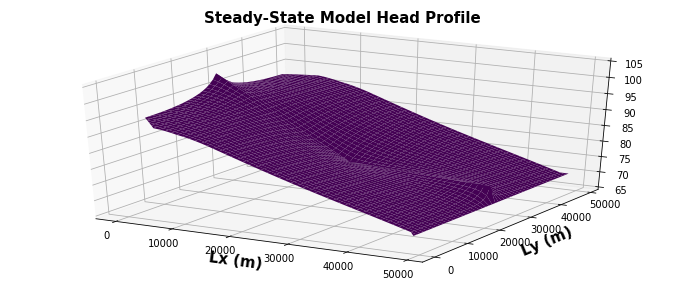

In [20]:
from mpl_toolkits.mplot3d import Axes3D

#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head['sp0'][0])
Z2 = Z.copy()
Z2[Z<1e-10] = np.nan
#print(Z2)
#print(Z)
#create surface and labels
surf = ax.plot_surface(X,Y,Z2, cmap = 'viridis', linewidth=0, label='head')
#fig_3d.colorbar(surf,shrink=0.5,aspect=150).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_zlim(65, 105)
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
plt.show(surf)